#### 「人狼」ゲームのシミュレーション
-  「人狼」ゲームには多数の変形版が存在するが，ここでは役割の数が最低限である単純なものを想定する。
   - プレイヤーの総数は9人とする。
   - このうち，人狼が2人，占い師が1人，残りが村人となる場合に，「村人+占い師」チームと「人狼」チームのそれぞれの勝利の確率がおおよそ等しくなることを以下のシミュレーションによって示す。
- プレイヤーへの役割の振り分けは，一様分布に従う確率変数によって行う。
  - 役割が3種類あるので，ありうる全ての役割の振り分けのパターン (下記の `role_patterns`) は，多項組合せで表現される。
  - 一様分布に従う確率変数による振り分けでは，各パターンがどれも等しい確率で発生しうることになる
- 以下のシミュレーションにおいては，「襲撃」でも「処刑」でも一様分布に従う確率変数によって対象を選択する。

In [1]:
import numpy as np
from math import factorial
import itertools as it
import scipy.stats


roles = ('W', 'S', 'V') # W: 人狼(werewolf), S: 占い師(seer), V: 村人(villager)
# m = (1, 1, 7) # 各役割の人数 (m_1, m_2, m_3)
m = (2, 1, 6) # 各役割の人数 (m_1, m_2, m_3) 
# m = (3, 1, 5) # 各役割の人数 (m_1, m_2, m_3)
# m_1 == 2: 勝率 V vs. W ~= 5/5 程度
# m_1 == 1: 勝率 V vs. W ~= 7/3 程度
# m_1 == 3: 勝率 V vs. W ~= 3/7 程度

seq_gen = (it.repeat(i, m_k) for i, m_k in zip(roles, m))
c = it.chain.from_iterable(seq_gen)
role_patterns = tuple(set(it.permutations(c))) # 順列の重複分を除外する
print(len(role_patterns))

# 多項係数（multinomial coefficient）
mult_coeff = factorial(np.sum(m))//np.prod([factorial(m_k) for m_k in m])
print(mult_coeff)

def is_game_over(players):
    nw = np.count_nonzero(players == 'W')
    nv = np.count_nonzero(players == 'V')
    won_by = '-'
    over = False
    if nw == 0:
        won_by = 'V'
        over = True
    elif nv <= nw:
        won_by = 'W'
        over = True
    return over, won_by


def play_werewolf_at_random(players, show_msg=False):
    dbg_print = lambda *args: None
    if show_msg:
        dbg_print = lambda *args: print(*args)

    at_night = True
    while True:
        idx_p = np.arange(len(players)) 
        
        if at_night: # Night
            dbg_print('## Night ##')
            idx_v = idx_p[[p in ('V', 'S') for p in players]]
            dbg_print('indices of villagers:', repr(idx_v))
            idx_v_to_kill = scipy.stats.randint.rvs(0, len(idx_v))
            dbg_print(f'Player {idx_v_to_kill} was killed, and revealed to be {players[idx_v_to_kill]}')
            players = np.delete(players, idx_v_to_kill)

        else: # Daytime
            dbg_print('## Day ##')
            dbg_print('indices of players:', repr(idx_p))
            idx_p_to_lynch = scipy.stats.randint.rvs(0, len(idx_p))
            dbg_print(f'Player {idx_p_to_lynch} was lynched, and revealed to be {players[idx_p_to_lynch]}')
            players = np.delete(players, idx_p_to_lynch)

        dbg_print('Remaining players:', players)

        over, won_by = is_game_over(players)
        if over:
            dbg_print('Game won by ', won_by)
            return won_by
            # break
        at_night = at_night ^ True

num_repeat = 1000

results = []
for i in range(num_repeat):
    patt_idx = scipy.stats.randint.rvs(0, len(role_patterns))
    players = np.array(role_patterns[patt_idx])
    # results.append(play_werewolf_at_random(players))
    results.append(play_werewolf_at_random(players, show_msg=True))

nv = np.count_nonzero(np.array(results) == 'V')
print(f'Win rate, V vs. W: {nv}--{num_repeat - nv}')


252
252
## Night ##
indices of villagers: array([0, 1, 2, 3, 4, 5, 6])
Player 1 was killed, and revealed to be V
Remaining players: ['V' 'V' 'V' 'S' 'V' 'V' 'W' 'W']
## Day ##
indices of players: array([0, 1, 2, 3, 4, 5, 6, 7])
Player 1 was lynched, and revealed to be V
Remaining players: ['V' 'V' 'S' 'V' 'V' 'W' 'W']
## Night ##
indices of villagers: array([0, 1, 2, 3, 4])
Player 1 was killed, and revealed to be V
Remaining players: ['V' 'S' 'V' 'V' 'W' 'W']
## Day ##
indices of players: array([0, 1, 2, 3, 4, 5])
Player 0 was lynched, and revealed to be V
Remaining players: ['S' 'V' 'V' 'W' 'W']
Game won by  W
## Night ##
indices of villagers: array([0, 1, 2, 4, 5, 7, 8])
Player 1 was killed, and revealed to be S
Remaining players: ['V' 'V' 'W' 'V' 'V' 'W' 'V' 'V']
## Day ##
indices of players: array([0, 1, 2, 3, 4, 5, 6, 7])
Player 2 was lynched, and revealed to be W
Remaining players: ['V' 'V' 'V' 'V' 'W' 'V' 'V']
## Night ##
indices of villagers: array([0, 1, 2, 3, 5, 6])
Player 1 

##### 解説
- 以下の解説のセルを正常に実行するには Notebook の最初から順にセルを実行しておく必要がある。


シーケンス t からコンストラクタ set(t) で [set 型](https://docs.python.org/ja/3/library/stdtypes.html#set-types-set-frozenset)のオブジェクトを作ると，重複した要素は除外される。

In [2]:
t1 = ('A', 'A', 'B', 'C', 'C')
s1 = set(t1) 
print(s1)

{'C', 'A', 'B'}


numpy.delete(arr, index) は配列 arr において先頭(0)を起点として index の位置にある要素を削除した配列を作る。

In [3]:
import numpy as np
index_to_delete = 0
arr_orig = np.array((98, 99, 100))
arr_mod = np.delete(arr_orig, index_to_delete)
print(repr(arr_mod))

array([ 99, 100])


np.count_nonzero(players == 'W') で players 中の 'W' の個数が得られる。 
- numpy.ndarray の players について，players == 'W' は，players と同じ shape の bool 型の配列となり，
players において 'W' に一致する要素の位置のみ True となる。

- bool型の配列 x に対して np.count_nonzero(x)  は 評価値が True である x の要素の個数を返す。

In [4]:
players = np.array(('W', 'W', 'S', 'V', 'V', 'V', 'V', 'V', 'V'))
print(repr(players.shape))
print(repr(players == 'W'))
print(repr((players == 'W').shape))
print(repr(np.count_nonzero(players == 'W')))

(9,)
array([ True,  True, False, False, False, False, False, False, False])
(9,)
2


`randint.rvs(lb, ub, size=n)` は離散型の一様分布に従う，要素数が n 個の標本値の配列を作る。

`size` を省略したときには，標本値が一つだけ出力される。

ただし，上記の一様分布の確率質量関数は $P(X = k) = \dfrac{1}{\text{ub} - \text{lb}}$ であり，
$k \in \{\text{lb}, \text{lb} + 1, \ldots, \text{ub} - 1\}$ である。


array([6, 2, 6, 6, 6, 1, 6, 1, 5, 5])
1


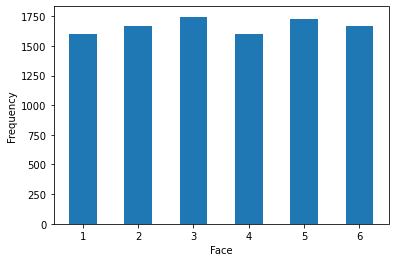

In [5]:
from scipy.stats import randint
import matplotlib.pyplot as plt
import numpy as np

DICE_MIN = 1
DICE_MAX = 6
lb = DICE_MIN
ub = DICE_MAX + 1
print(repr(randint.rvs(lb, ub, size=10)))
print(repr(randint.rvs(lb, ub)))
ret = plt.hist(randint.rvs(lb, ub, size=10000), bins=np.arange(lb, ub+1), align='left', rwidth=0.5)
plt.xlabel('Face')
retval = plt.ylabel('Frequency')

##### 多項組合せの生成
- 標準ライブラリの [itertools.combinations](https://docs.python.org/ja/3/library/itertools.html#itertools.combinations) では2項組合せしか生成できない。
- 2項組合せ(n個のものから r個を取り出す(選ぶ)組合せ)では，対象の要素を二つのグループに振り分けることになる。
  - ここで，itertools.combinations において，二つのグループの一方は「取り出す(選ぶ)」対象となるグループであり，もう一方は，暗黙のうちに，「取り出さない(選ばない)」対象となるグループである。
  - グループの数が二つしかないので，一方のグループが確定すれば，もう一方のグループが確定する
    - 「人狼」ゲームの例でいえば，「占い師」が存在せず，役割が「人狼」，「村人」の2種類であれば，ありうる全ての役割の振り分けのパターンを2項組合せで表現できる ( itertools.combinations で生成できる)。

In [6]:
import itertools as it
players = (0, 1, 2, 3)
num_wolves = 2
wolves_combos = tuple(it.combinations(players, num_wolves))
print(wolves_combos)
patterns = tuple(tuple( 'W' if i in wolves else 'V' for i in players) for wolves in wolves_combos)
print('\n'.join(repr(p) for p in patterns))

((0, 1), (0, 2), (0, 3), (1, 2), (1, 3), (2, 3))
('W', 'W', 'V', 'V')
('W', 'V', 'W', 'V')
('W', 'V', 'V', 'W')
('V', 'W', 'W', 'V')
('V', 'W', 'V', 'W')
('V', 'V', 'W', 'W')


- 生成した2項組合せの個数は，2項係数 $\displaystyle {}_n C_{r} = \binom{n}{r} = \dfrac{n!}{r! (n-r)!}$ に一致する。
- 上記の分母の各項について， $r + (n - r) = n$ が成立する。

In [14]:
from math import factorial
print(len(patterns))
# print(math.comb(len(players), num_wolves)) for Python 3.8 or later
n = len(players)
r = num_wolves
print(factorial(n)/(factorial(r)*factorial(n - r)))


6
6
6.0


- 一方，多項組合せは，$M$ 個のものを 各グループに所属する要素の個数が $m_k$ 個となるように $K$ 種類のグループに分類するときの組合せである。ただし， $ M = \sum_{k=1}^{K} m_k $ という制約を設ける。
  - つまり，上記の2項組合せは $K = 2$，$m_1 = r$，$m_2 = n - r$ の場合の多項組合せとなる。
- 多項組合せの生成は以下のプログラムのように実装できる。
- 生成した多項組合せの個数は，多項係数 $
   \left( 
    \begin{matrix}
        M \\
        m_1,\ldots,m_K 
    \end{matrix}
   \right) =
\dfrac{ M! } {\prod_{k=1}^{K} {m_k !} }
$  
に一致する。


In [8]:
import itertools as it
from math import factorial
import numpy as np


def multinomial_combinations(items, m):
    seq_gen = (it.repeat(i, m_k) for i, m_k in zip(items, m))
    t = it.chain.from_iterable(seq_gen)

    for i in set(it.permutations(t)):
        yield i

items = ('W', 'S', 'V')
m = (2, 1, 6) # m[0]: no. of 'W's, m[1]: no. of 'S's, m[2]: no. of 'V's
t = tuple(multinomial_combinations(items, m))
print(len(t))
print(factorial(np.sum(m))//np.prod([factorial(m_k) for m_k in m]))
print('\n'.join(repr(c) for c in multinomial_combinations(items, m)))

252
252
('W', 'V', 'W', 'V', 'V', 'V', 'S', 'V', 'V')
('V', 'V', 'V', 'S', 'V', 'W', 'W', 'V', 'V')
('V', 'S', 'W', 'W', 'V', 'V', 'V', 'V', 'V')
('V', 'S', 'W', 'V', 'V', 'V', 'V', 'W', 'V')
('V', 'V', 'V', 'V', 'W', 'S', 'V', 'V', 'W')
('V', 'V', 'S', 'V', 'V', 'V', 'W', 'W', 'V')
('V', 'W', 'W', 'V', 'S', 'V', 'V', 'V', 'V')
('V', 'V', 'V', 'W', 'V', 'W', 'S', 'V', 'V')
('W', 'V', 'V', 'V', 'V', 'W', 'S', 'V', 'V')
('S', 'V', 'V', 'V', 'W', 'V', 'V', 'V', 'W')
('V', 'W', 'V', 'V', 'W', 'V', 'V', 'V', 'S')
('V', 'W', 'V', 'S', 'V', 'V', 'V', 'V', 'W')
('V', 'V', 'V', 'V', 'W', 'V', 'W', 'V', 'S')
('V', 'W', 'V', 'V', 'V', 'S', 'V', 'W', 'V')
('V', 'V', 'S', 'V', 'W', 'V', 'V', 'W', 'V')
('V', 'W', 'V', 'V', 'V', 'V', 'W', 'V', 'S')
('V', 'S', 'V', 'W', 'V', 'V', 'W', 'V', 'V')
('S', 'V', 'V', 'W', 'V', 'V', 'V', 'W', 'V')
('V', 'S', 'W', 'V', 'V', 'V', 'W', 'V', 'V')
('W', 'V', 'W', 'V', 'S', 'V', 'V', 'V', 'V')
('W', 'S', 'V', 'V', 'V', 'W', 'V', 'V', 'V')
('V', 'V', 'V', 'S', 'V', 

上記のセルの `multinomial_combinations()` の実装において，
```
    seq_gen = (it.repeat(i, m_k) for i, m_k in zip(items, m))
    t = it.chain.from_iterable(seq_gen)
```
は，`items[k]` が `m[k]` 個だけ含まれるシーケンスの[ジェネレータ](https://docs.python.org/ja/3/tutorial/classes.html#generators) を作る
([`it.chain.from_iterable`](https://docs.python.org/ja/3/library/itertools.html#itertools.chain.from_iterable))。

In [9]:
import itertools as it

items = ('W', 'S', 'V')
m = (2, 1, 6) # m[0]: no. of 'W's, m[1]: no. of 'S's, m[2]: no. of 'V's
seq_gen = (it.repeat(i, m_k) for i, m_k in zip(items, m))
seq_gen1, seq_gen2 = it.tee(seq_gen) # seq_gen のコピーを作る(ジェネレータを表示の都合上，一度評価してしまうと使えなくなるので)
# print(tuple(tuple(s) for s in seq_gen1))
print(tuple(seq_gen1))
print(tuple(seq_gen1))
t = it.chain.from_iterable(seq_gen2)
t = tuple(t)
print(t)


(repeat('W', 2), repeat('S', 1), repeat('V', 6))
()
('W', 'W', 'S', 'V', 'V', 'V', 'V', 'V', 'V')


`items[k]` が `m[k]` 個だけ含まれるシーケンス t を並べ替えて作れる全ての順列は，
[`it.permutations(t)`](https://docs.python.org/ja/3/library/itertools.html#itertools.permutations) で生成できる。
`it.permutations(t)` は `t` の構成要素の値が同じでも，`t` の中での場所が違えば別の要素とみなして順列を生成する。

In [10]:
t = t[::-1] # 各順列の違いを示すため逆順にする
print('\npermutations:')
num_perms_to_show = 16
print('\n'.join(repr(p) for p in it.islice(it.permutations(t), num_perms_to_show)))


permutations:
('V', 'V', 'V', 'V', 'V', 'V', 'S', 'W', 'W')
('V', 'V', 'V', 'V', 'V', 'V', 'S', 'W', 'W')
('V', 'V', 'V', 'V', 'V', 'V', 'W', 'S', 'W')
('V', 'V', 'V', 'V', 'V', 'V', 'W', 'W', 'S')
('V', 'V', 'V', 'V', 'V', 'V', 'W', 'S', 'W')
('V', 'V', 'V', 'V', 'V', 'V', 'W', 'W', 'S')
('V', 'V', 'V', 'V', 'V', 'S', 'V', 'W', 'W')
('V', 'V', 'V', 'V', 'V', 'S', 'V', 'W', 'W')
('V', 'V', 'V', 'V', 'V', 'S', 'W', 'V', 'W')
('V', 'V', 'V', 'V', 'V', 'S', 'W', 'W', 'V')
('V', 'V', 'V', 'V', 'V', 'S', 'W', 'V', 'W')
('V', 'V', 'V', 'V', 'V', 'S', 'W', 'W', 'V')
('V', 'V', 'V', 'V', 'V', 'W', 'V', 'S', 'W')
('V', 'V', 'V', 'V', 'V', 'W', 'V', 'W', 'S')
('V', 'V', 'V', 'V', 'V', 'W', 'S', 'V', 'W')
('V', 'V', 'V', 'V', 'V', 'W', 'S', 'W', 'V')


`[::-1]` は，[スライス表記](https://docs.python.org/ja/3/reference/expressions.html#slicings) 
`[lower_bound:upper_bound:stride]` において，`lower_bound`, `upper_bound` を省略し，
`stride` に -1 を指定したものであり，対象のシーケンスの順序を逆順にしたシーケンスを作る。

In [11]:
print(('a', 'b', 'c', 'd')[::-1])
print([1, 2, 3, 4][::-1])
print(repr(np.arange(4)[::-1]))

('d', 'c', 'b', 'a')
[4, 3, 2, 1]
array([3, 2, 1, 0])


`it.islice(i, r)` はイテレータ `i` から最初の `r` 個の要素を取り出す。

In [12]:
tuple(it.islice([0, 1, 2, 3], 2))

(0, 1)

上記の順列のうち，重複している順列を set で除外すれば，要素数が $M$ ($ = \sum_{k=1}^K m_k$)個のシーケンスに対して
$K$ 種類のグループに，$m_k$ 個ずつ分類するときの多項組合せを全て生成できる。

In [13]:
print('\n'.join(repr(p) for p in it.islice(set(it.permutations(t)), num_perms_to_show)))

('V', 'V', 'V', 'S', 'V', 'W', 'W', 'V', 'V')
('W', 'V', 'W', 'V', 'V', 'V', 'S', 'V', 'V')
('V', 'S', 'W', 'W', 'V', 'V', 'V', 'V', 'V')
('V', 'V', 'V', 'V', 'W', 'S', 'V', 'V', 'W')
('V', 'S', 'W', 'V', 'V', 'V', 'V', 'W', 'V')
('V', 'V', 'S', 'V', 'V', 'V', 'W', 'W', 'V')
('V', 'W', 'W', 'V', 'S', 'V', 'V', 'V', 'V')
('V', 'V', 'V', 'W', 'V', 'W', 'S', 'V', 'V')
('W', 'V', 'V', 'V', 'V', 'W', 'S', 'V', 'V')
('S', 'V', 'V', 'V', 'W', 'V', 'V', 'V', 'W')
('V', 'W', 'V', 'V', 'W', 'V', 'V', 'V', 'S')
('V', 'V', 'V', 'V', 'W', 'V', 'W', 'V', 'S')
('V', 'W', 'V', 'S', 'V', 'V', 'V', 'V', 'W')
('V', 'W', 'V', 'V', 'V', 'S', 'V', 'W', 'V')
('V', 'V', 'S', 'V', 'W', 'V', 'V', 'W', 'V')
('V', 'W', 'V', 'V', 'V', 'V', 'W', 'V', 'S')


#### 参考文献
- https://en.wikipedia.org/wiki/Mafia_(party_game) : 「人狼」ゲームの原型とされるゲーム
- [Werewolf](https://www.eblong.com/zarf/werewolf.html) : 上記 Mafia におけるマフィアの役割を人狼に置き換えたゲームを最初に考案したとされる Andrew Plotkin による説明
- https://ja.wikipedia.org/wiki/%E6%B1%9D%E3%81%AF%E4%BA%BA%E7%8B%BC%E3%81%AA%E3%82%8A%E3%82%84%3F : 上記 Werewolf に基づく商品